# Implementing Batch Normalization

In this notebook I will go over Ioffe and Svegedy's batch normalization, as well as an example implementation in Keras.


### Batch Normalization

- Original paper by Ioffe and Szegedy. <a href="https://arxiv.org/abs/1502.03167"> here. </a>

- Insert a batch normalization before or after nonlinearities?
<a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture6.pdf"> Usage explanation </a>

- For an explanation of the math and implementation in tensorflow. <a href="https://towardsdatascience.com/pitfalls-of-batch-norm-in-tensorflow-and-sanity-checks-for-training-networks-e86c207548c8"> Pitfalls of Batch Norm in TensorFlow and Sanity Checks for Training Networks </a>

- Also this post <a href="https://towardsdatascience.com/how-to-use-batch-normalization-with-tensorflow-and-tf-keras-to-train-deep-neural-networks-faster-60ba4d054b73">How to use Batch Normalization with TensorFlow and tf.keras to train deep neural networks faster</a>


## Notes on Batch Normalization

### The Problem

If $g(x)$ represents the sigmoid activayion function, as $| x |$ increases, $g^\prime(x)$ tends to zero. For a given hidden layer being trained in a neural network, any unit with an exceptionally large absolute output will create an activation that is large in absolute value. The result is a unit with an exceptionally small gradient, that cannot update its own weights greatly,  nor pass back a significant gradient to train the weights before it.

<img src="https://cdn-images-1.medium.com/max/1500/0*K5rfrS3lIXmDh6p6." height=300 width=500>


So if a large portion of our neurons are outputting exceptionally positive or negative values, then the large area that those neurons are connected to will receive little or no gradient propagation and thus fail to train. This is the vanishing gradient problem, and is largely solved by using a ReLU activation with small learning rates. However, batch normalization is actually an effective method to deal with the tendency of saturable activation functions to have vanishing gradients.








### How it Works

If we take a unit in a layer with a sigmoid activation function we would like to see it produce an activation input that is close to zero. This way we can ensure that the unit will receive a substantial gradient that will allow the update of its own weights as well as the weights of the units in previous layers during propagation.

<img src="img/sweet.png">



Unfortunately, the linear activations of any unit can very wildly as a result of changes in previous layers. Batch normalization seeks to address this instability and tendency towards a vanishing gradient by applying preprocessing of inputs at the layer-level. Specifically batch normilation seeks to maintain a unit gaussian distribution of each layers activation inputs that is constant despite changes of the network and variations in data from batch to batch.




### The Transformation

Like normalization in regular preprocessing, with batch normalization we seek a zero-centered, unit variance distribution of batch inputs to our activation functions. During training time we take an activation input $x$ and subtract it by the batch mean $\mu_{B}$
to achieve a zero centered distribution.



$\hat{x} = x_i-\mu_{B}$
 





Next we take $x$ and divide it by the batch variance and a small number to prevent division by zero $\sigma_{B}+\epsilon$. This ensures that all activation inputs reside in the "sweet spot" of the sigmoid activation, where all inputs are close to zero.


$\hat{x} = \frac{x_i-\mu_{B}}{\sigma_{B}+\epsilon}$


Lastly we put $\hat{x}$ through a linear transformation to scale and shift the output of batch normalization $y_i$. Ensuring that this normalizing effect is maintained despite the changes in the network during back propagation. 

$y_i=\lambda *\hat{x_i}+\beta$


All of this results in a constant flow of batch activation inputs that do not vary into the saturable regions of the activation function.

<img src="img/sig4.png">




During test time, we do not use batch mean or variance, instead as we train we calculate a moving average and variance to estimate these values for the training population. This simply means collecting the batch means and variances and averaging them together to form an estimate of population mean and variance. These population estimates are used in the batch normalization layers when we propagate a test-sample through the network.






### Benefits of Batch Normalization


After reading [1] I distill the benefits of batch normalization down to the following.





#### 1. Helps prevent vanishing gradient in networks with saturable nonlinearities (sigmoid, tanh, etc)



With Batch normalization we ensure that the inputs of any activation function do not vary into saturable regions by transforming the distribution of those inputs to be unit gaussian (zero-centered and unit variance). This should speed up training time. (as gradients are being passed back without vanishing.)

#### 2. Regularizes the model

Maybe. Ioffe and Svegeddy make this claim but dont really back it up. Its possible that we are normalizaing the network by constricting the scale of individual neuron outputs, but I need to read further to see if this actually has a normalizing effect.



#### 3.  Allows for Higher Learning Rates

By preventing issues with vanishing gradient during training, we can afford to set higher learning rates.

Batch normalization also reduces dependence on parameter scale. Large learning rates can increase the scale of layer parameters which cause the gradients to amplify as they are passed back during back propagation. I need to read more about this.


# Keras Implementation

## Imports

In [1]:
import tensorflow as tf 
import numpy as np
import os

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Model, Sequential
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.layers import MaxPooling2D, Dropout, Flatten

Using TensorFlow backend.


## Data Load and Preprocessing


In this notebook we use the Cifar 100 toy dataset, as it is reasonably challenging, and won't take forever to train. The only preprocessing performed is a zero-centering, and a image variation generator.

In [2]:
from keras.datasets import cifar100
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

#scale and regularize the dataset
x_train = (x_train-np.mean(x_train))
x_test = (x_test - x_test.mean())

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#onehot encode the target classes
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train,
                                     y = y_train,
                                    batch_size=80,)

## Constructing the Model in Keras

Convolutional blocks composed of 2 stacked 3x3 convolutions followed by a max pool and dropout. The final layer is a fully connected layer with 100 nodes. We will be constructing 4 different networks, each with either sigmoid or ReLU activations and either with batch normalization or without. We will compare the time to convergence and validation loss of each of the networks to its colleagues.

In [3]:
def conv_block_first(model, bn=True, activation="sigmoid"):
    
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(MaxPooling2D())
    model.add(Dropout(0.15))
    return model

def conv_block(model, bn=True, activation = "sigmoid"):
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(MaxPooling2D())
    model.add(Dropout(0.15))
    return model

def conv_block_final(model, bn=True, activation = "sigmoid"):
    
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Conv2D(5,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Flatten())
    return model

def fn_block(model):
    model.add(Dense(100, activation = "softmax"))
    return model

def build_model(blocks=3, classes=5, bn=True, activation = "sigmoid"):
    model = Sequential()
    
    model = conv_block_first(model, bn=bn, activation=activation)
    
    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, activation = activation)
        
    model = conv_block_final(model, bn=bn, activation=activation)
    model = fn_block(model)
    
    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]): 
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

In [4]:
sigmoid_without_bn = build_model(blocks = 5, classes = 100, bn=False, activation = "sigmoid")
sigmoid_without_bn = compile_model(sigmoid_without_bn)

sigmoid_with_bn = build_model(blocks = 5, classes = 100, bn=True, activation = "sigmoid")
sigmoid_with_bn = compile_model(sigmoid_with_bn)


relu_without_bn = build_model(blocks = 5, classes = 100, bn=False, activation = "relu")
relu_without_bn = compile_model(relu_without_bn)

relu_with_bn = build_model(blocks = 5, classes = 100, bn=True, activation = "relu")
relu_with_bn = compile_model(relu_with_bn)

## Model Training

### Sigmoid without Batch Normalization

In [5]:
import time

start = time.time()

model_checkpoint = ModelCheckpoint('models/sigmoid_without_bn.h5',
                                   save_best_only = True)


history1 = sigmoid_without_bn.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=20,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Epoch 1/25
2000/2000 [==============================] - 109s 54ms/step - loss: 4.6058 - acc: 0.0093 - val_loss: 4.6052 - val_acc: 0.0100
Epoch 2/25
2000/2000 [==============================] - 109s 54ms/step - loss: 4.6057 - acc: 0.0088 - val_loss: 4.6053 - val_acc: 0.0100
Epoch 3/25
2000/2000 [==============================] - 107s 53ms/step - loss: 4.6057 - acc: 0.0088 - val_loss: 4.6052 - val_acc: 0.0100
Epoch 00003: early stopping
Training time:  5.428168642520904  minutes


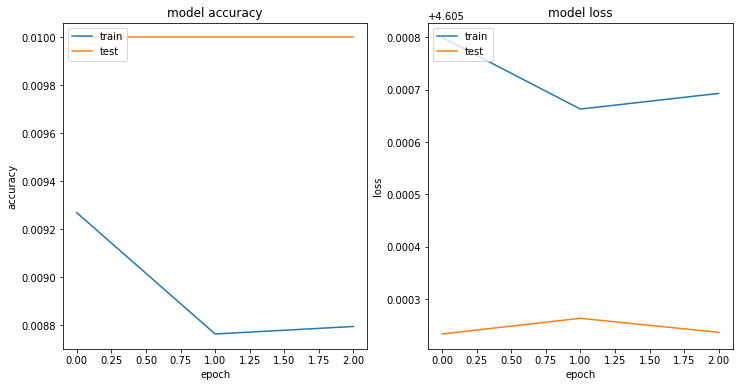

In [6]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Sig w/o BN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Sig w/o BN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Sigmoid with Batch Normalization

In [7]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/sigmoid_with_bn.h5',
                                   save_best_only = True)


history2 = sigmoid_with_bn.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  27.320756228764854  minutes


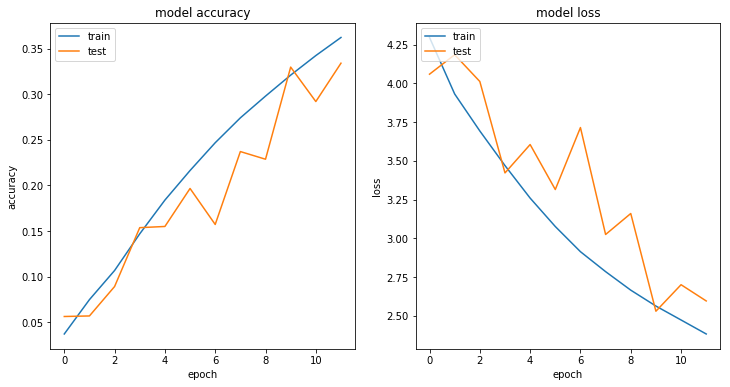

In [8]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Sig w/ BN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Sig w/ BN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## ReLU Without Batch Normalization

In [9]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/ReLU_without_BN.h5',
                                   save_best_only = True)


history3 = relu_without_bn.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=20,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  11.825861970583597  minutes


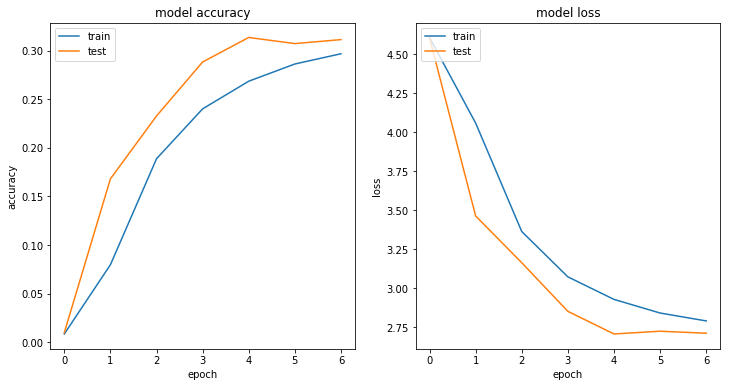

In [10]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('ReLU w/o BN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('ReLU w/o BN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## ReLU with Batch Normalization

In [11]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/ReLU_with_bn.h5',
                                   save_best_only = True)


history4 = relu_with_bn.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=25,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  33.85266766150792  minutes


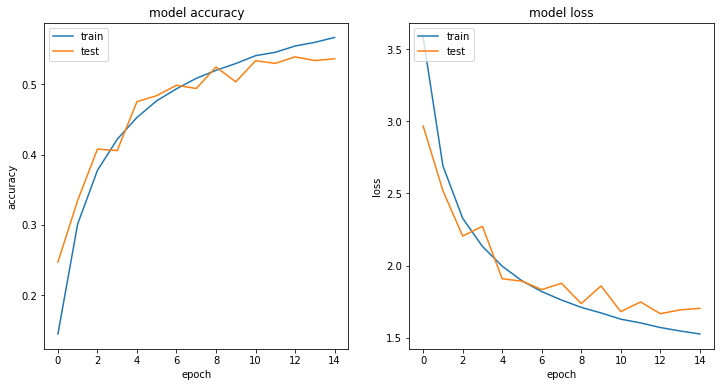

In [12]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('ReLU w/ BN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('ReLU w/ BN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Comparing Training Times

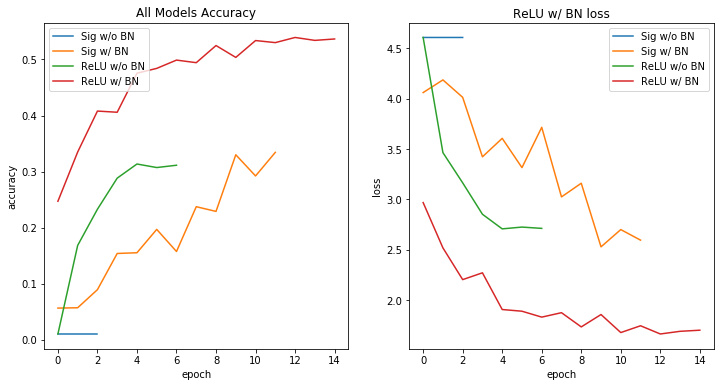

In [13]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.plot(history3.history['val_acc'])
plt.plot(history4.history['val_acc'])
plt.title('All Models Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Sig w/o BN', 'Sig w/ BN', 'ReLU w/o BN', 'ReLU w/ BN'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.title('ReLU w/ BN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Sig w/o BN', 'Sig w/ BN', 'ReLU w/o BN', 'ReLU w/ BN'], loc='upper right')
plt.show()

## Ideas for Future Notebooks:



Architecture Improvements
- Implement all convolutional network with global average pooling.

Parameter Tuning
- Experiment with learning rates. 
- what about the steps per batch.

Applications
- How do we predict with a .h5 file and serve with a REST api? 
- Look at implementing this model in TensorFlow.


## Conclusion

We went over what batch normalization is, its effect on the training process of a network, and an implementation with Keras. In the next notebook I will focus on global average pooling and its implementation in a convnet.

We will continue to improve on our current model architecture, and eventually have a general understanding of neural network architecture.

### Further reading

Below are some more recent research papers about neural network normalization.

<a href="https://arxiv.org/abs/1702.03275v2"> How Does Batch Normalization Help Optimization? (No, It Is Not About Internal Covariate Shift)</a>



<a href="https://arxiv.org/abs/1702.03275v2">Batch Renormalization: Towards Reducing Minibatch Dependence in Batch-Normalized Models </a>



<a href="https://arxiv.org/abs/1607.06450v1">Layer Normalization</a>



<a href="https://arxiv.org/abs/1602.07868v3"> Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks</a>



<a href="https://arxiv.org/abs/1803.08494v3">Group Normalization</a>
